In [227]:
# Imports
import os, warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec


import tensorflow as tf
from tensorflow import keras

from keras import layers
from keras import Sequential

from keras.api.layers import Dense, Flatten, MaxPooling2D,  Dropout, BatchNormalization, Conv2D, LeakyReLU, Dropout

from keras.api.utils import image_dataset_from_directory
from keras.api.layers import Rescaling

from keras.api.optimizers import Adam
from keras.api.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


from keras.api.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import zipfile
import random






# Project 2 - Veggie Classification

For this assignment you'll need to classify some images of vegetables. 

## Deliverables

Please submit your files into Moodle as follows:
<ul>
<li> A zipped .h5 model that has been trained. See the notes towards the end of the file. 
<li> Your .ipynb file. 
<li> A note (~1 to 2 paragraphs) in the comments of Moodle noting what you did to improve accuracy beyond just making a model. 
</ul>

### Grades

<ul>
<li> Accuracy - 60%
<li> Code - readable and logical - 20%
<li> Explainatory note - 20%
</ul>

## Load Training and Validation Data

Please download the zip file from moodle and place it into your folder. If running on Colab you'll need to load it into the workspace. 

#### Colab and Files

You can load files into your Colab workspace via a drag and drop, however this file storage is temporary and will go away when you end your runtime. You can also use your Google drive to store it without having to load it multiple times - there are lots of guides online to setting this up. 

#### Temporary Files

If there are temporary files generated anywhere in the image folders you will need to remove them or you will probably get weird errors. For example, on a Mac (which I'm using to make this), there are temporary files that start with "._". If these appear for you, you can clear them via:
<ul>
<li> Mac: open a terminal at the top level of the image folder and run "dot_clean -n ."
<li> Windows: open a command prompt at the top level of the image folder and run "find . -name "._*" -exec rm '{}' \; -print"
</ul>

If this doesn't work, or if there are any other temporary files created in your file system you can remove them any other way - e.g. use search to find the files and remove them, sort by filetype and delete, etc... The commands above are just shortcuts. 

#### File Naming

Once things are unzipped ensure that the paths are correct and match your file paths. 

#### Loading from Google Drive

You can also use an adaptation of the code below to load the file from your Google Drive if you're in Colab. You'll get some permission prompts if you haven't done this before. 

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

#!cp "/content/drive/My Drive/Vegetables.zip" "Vegetables.zip"

In [ ]:
# UNZIP - Ensure that the filename is correct
zip_name = "Vegetables.zip"

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall()

In [172]:
# Declare Size Variables - Needed for Compressing
batch_size = 64
train_samples = 10000
epochs = 5

In [228]:
# Generate Datasets - you can change this if desired
# ENSURE FILE PATHS MATCH CORRECTLY
IMAGE_SIZE=(224,224)
train_dir='Vegetables/train'
val_dir='Vegetables/validation'

# Load training data
train_ds = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size = IMAGE_SIZE,
    shuffle=True,
)

val_ds = image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    image_size = IMAGE_SIZE,
)



Found 10000 files belonging to 10 classes.
Found 2000 files belonging to 10 classes.


<font color='red'>Cell Code</font>

This code counts the number of images in each vegetable class within the training dataset by iterating over the class folders in train_dir. It stores the results in the class_counts dictionary and then prints the counts.

In [229]:
class_counts = {veg_cls: len(os.listdir(os.path.join(train_dir, veg_cls))) for veg_cls in os.listdir(train_dir)}
print(class_counts)

{'Bean': 1000, 'Bottle_Gourd': 1000, 'Brinjal': 1000, 'Broccoli': 1000, 'Cabbage': 1000, 'Capsicum': 1000, 'Cauliflower': 1000, 'Cucumber': 1000, 'Pumpkin': 1000, 'Tomato': 1000}


#### Training and Validation Data

After the file has been unzipped and loaded into datasets, you should see:

Found 20000 files belonging to 10 classes.
Found 4000 files belonging to 10 classes.

The first is the training dataset, the second is the validation dataset. 

<font color='red'>Cell Code</font>

This code visualizes one sample image from each category in the training dataset to provide a quick overview of the different vegetable classes. It loads the first image from each folder in the training directory, normalizes the image pixels, and displays them in a 3x5 grid using Matplotlib. This is helpful for verifying dataset structure, checking image quality, and ensuring class balance before training the model.

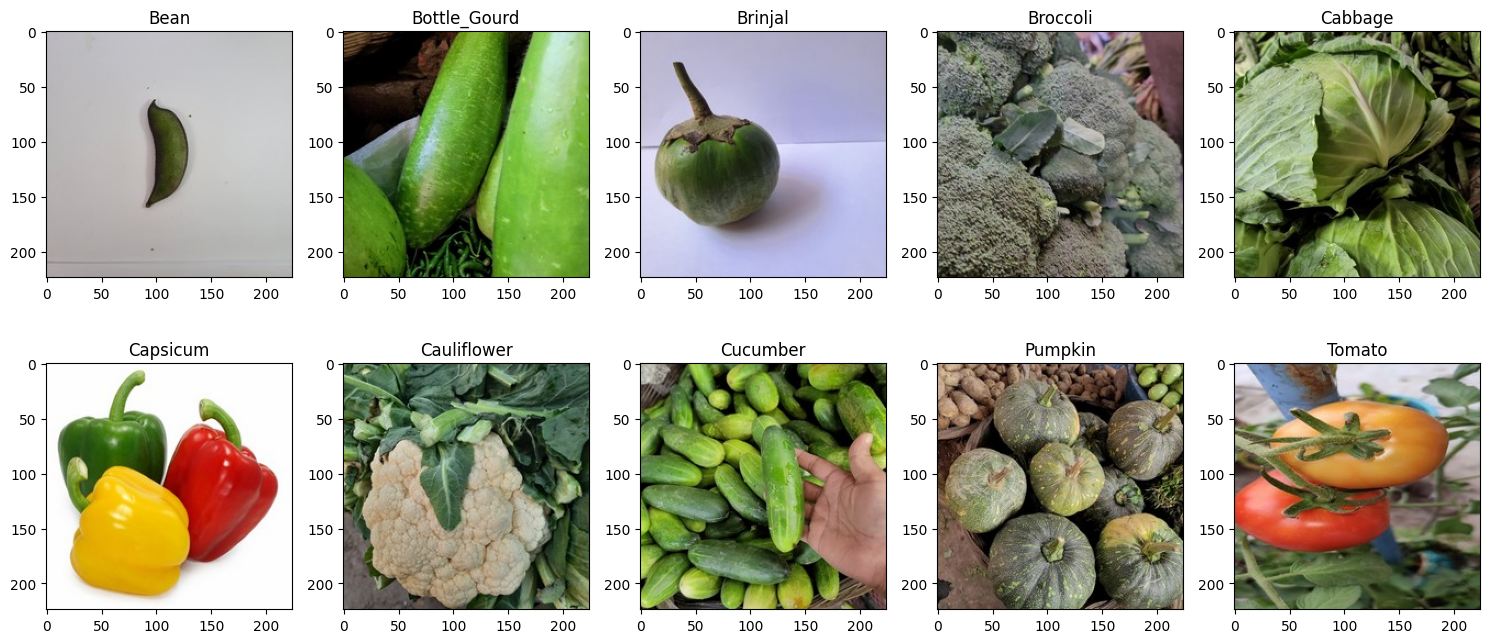

In [230]:

train_path = train_dir
validation_path = val_ds
test_path = "Vegetables/test"

image_categories = os.listdir('Vegetables/train')

def plot_images(image_categories):
    '''
     Plot vegetables
    '''
    # Create a figure
    plt.figure(1,figsize=(15, 10))
    for i, cat in enumerate(image_categories):
        
        #load images for the category
        image_path = train_path + '/' + cat
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[i]
        first_image_path = image_path + '/' + first_image_of_folder
        img = image.load_img(first_image_path)
        img_arr = image.img_to_array(img)/255

        #create subplot and plot the images
        plt.subplot(3, 5, i+1)
        plt.title(cat)
        plt.imshow(img_arr)
        
    plt.tight_layout()

plot_images(image_categories)

<font color='red'>Cell Code</font>

This code defines a Convolutional Neural Network (CNN) architecture using Keras' Sequential model. The network is structured into several blocks, each containing convolutional layers followed by batch normalization, Leaky ReLU activation, and max pooling layers for downsampling.

- First Block: A Conv2D layer with 16 filters and a kernel size of (7,7) is applied, followed by batch normalization and Leaky ReLU activation with an alpha of 0.1 to introduce non-linearity. The use_bias=False and glorot_normal kernel initializer are used to initialize the weights.
- Second Block: A smaller Conv2D layer with 32 filters and a kernel size of (5,5) follows, with valid padding and no bias. It is followed by batch normalization and Leaky ReLU activation. A MaxPooling2D layer with a stride of 2 is used to reduce the spatial dimensions.
- Third Block: Another convolutional layer with 64 filters and a (3,3) kernel is added, followed by batch normalization and Leaky ReLU. Max pooling is again applied with a stride of 2 for downsampling.
- Fourth Block: A convolutional layer with 128 filters and a (3,3) kernel follows, applying batch normalization, Leaky ReLU, and max pooling to continue feature extraction.
- Classifier: After the convolutional layers, the model is flattened, and a fully connected Dense layer with 128 neurons and ReLU activation is added. A Dropout layer with a rate of 0.3 is used for regularization to prevent overfitting. Finally, a Dense layer with 10 output units and softmax activation is added for multi-class classification, corresponding to 10 output classes.

In [ ]:


# Do Modelling Stuff
#######################

model = Sequential()

#first block
model.add(Conv2D(input_shape=(224, 224, 3), kernel_size=(7,7), filters=16, padding='same', use_bias=False, activation=None, kernel_initializer='glorot_normal'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(alpha=0.1))

#second block
model.add(Conv2D(kernel_size=(5,5), filters=32, padding='valid', use_bias=False, activation=None, kernel_initializer='glorot_normal'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(strides=2, padding='valid'))

#third block
model.add(Conv2D(kernel_size=(3,3), filters=64, padding='same', use_bias=False, activation=None, kernel_initializer='glorot_normal'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(strides=2, padding='valid'))

#fourth block (new)
model.add(Conv2D(kernel_size=(3,3), filters=128, padding='same', use_bias=False, activation=None, kernel_initializer='glorot_normal'))
model.add(BatchNormalization(axis=3))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(strides=2, padding='valid'))

# Classifier
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

<font color='red'>Cell Code</font>

This line compiles the model by specifying the optimization strategy, loss function, and evaluation metric. The Adam optimizer is used with a low learning rate of 0.0001 to ensure gradual and stable updates during training. The loss function 'categorical_crossentropy' is appropriate for multi-class classification problems where target labels are one-hot encoded. The model's performance will be monitored using the 'accuracy' metric.

In [184]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

<font color='red'>Cell Code</font>

This cell code prints key information about the dataset. It first calculates and displays the number of batches in the training and validation datasets by converting them to lists. train_ds.cardinality() is then used to determine the number of batches in the training dataset using TensorFlow's built-in method. Finally, a dictionary called idx_to_class is created to map numerical class indices to their corresponding class names, which is useful for interpreting model predictions. The resulting mapping is printed for reference.

In [185]:
print("Train batches:", len(list(train_ds)))
print("Val batches:", len(list(val_ds)))
print(train_ds.cardinality())

idx_to_class = {idx: name for idx, name in enumerate(train_ds.class_names)}
print(idx_to_class)


Train batches: 313
Val batches: 63
tf.Tensor(313, shape=(), dtype=int64)
{0: 'Bean', 1: 'Bottle_Gourd', 2: 'Brinjal', 3: 'Broccoli', 4: 'Cabbage', 5: 'Capsicum', 6: 'Cauliflower', 7: 'Cucumber', 8: 'Pumpkin', 9: 'Tomato'}


<font color='red'>Cell Code</font>

This block of code retrieves a single batch of images and their corresponding labels from the training dataset using train_ds.take(1), which returns a batch iterator. It then prints the shapes of the images and labels tensors to provide information on the dimensions of the data. The code uses tf.argmax(labels[0]) to determine the index of the class with the highest probability in the one-hot encoded label, then converts this index to its corresponding class label using the idx_to_class dictionary. Finally, it prints the class name associated with the label for the first image in the batch.

In [186]:
#take a batch from the train dataset and analyze it
for images, labels in train_ds.take(1):  
    print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")
    class_number = tf.argmax(labels[0]).numpy()
    print(idx_to_class[class_number])

Images shape: (32, 224, 224, 3), Labels shape: (32, 10)
Cucumber


<font color='red'>Cell Code</font>

This code sets up data augmentation and training configurations for a deep learning model using Keras. It first defines two callbacks: EarlyStopping and ReduceLROnPlateau. The EarlyStopping callback halts training if the validation accuracy does not improve for 5 consecutive epochs, while Restore_best_weights=True ensures the best model weights are retained. The ReduceLROnPlateau callback reduces the learning rate by a factor of 0.5 when the validation loss plateaus for 5 epochs, with a minimum learning rate set to 1e-6.

The code then sets up data augmentation using ImageDataGenerator for the training data (train_datagen) and simple rescaling for the validation data, val_datagen. The train_datagen includes various transformations like rotation, width/height shifts, zoom, horizontal flipping, and shear, which help improve model generalization.

Both the training and validation datasets are loaded using the flow_from_directory() method, which reads images from directories, and processes them in batches for model training. The fit() function trains the model for up to 50 epochs with the defined callbacks, utilizing the generators for both the training and validation sets.

In [ ]:
early_stopping = EarlyStopping( patience=5, monitor='val_accuracy', restore_best_weights=True, mode='max' )
lr_scheduler = ReduceLROnPlateau( monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1 )

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical'
)

history = model.fit(train_generator, validation_data=val_generator, batch_size=batch_size, epochs=50, callbacks=[early_stopping, lr_scheduler])

Found 10000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 898s 6s/step - accuracy: 0.2870 - loss: 2.2958 - val_accuracy: 0.1550 - val_loss: 2.2946 - learning_rate: 1.0000e-04
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 842s 5s/step - accuracy: 0.5059 - loss: 1.3584 - val_accuracy: 0.2720 - val_loss: 2.6561 - learning_rate: 1.0000e-04
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 812s 5s/step - accuracy: 0.5829 - loss: 1.1483 - val_accuracy: 0.6325 - val_loss: 1.1330 - learning_rate: 1.0000e-04
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 814s 5s/step - accuracy: 0.6264 - loss: 1.0577 - val_accuracy: 0.7365 - val_loss: 0.8564 - learning_rate: 1.0000e-04
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 816s 5s/step - accuracy: 0.6594 - loss: 0.9444 - val_accuracy: 0.8360 - val_loss: 0.5158 - learning_rate: 1.0000e-04
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 815s 5s/step - accuracy: 0.6807 - loss: 0.9121 - val_accuracy: 0.8120 - val_loss: 0.5424

## Interpretation 

The model is being trained on a dataset containing 10,000 training images and validated on 2,000 images. These are evenly divided across 10 classes. 

The model shows a strong learning curve, with rapid improvements in early epochs and peak validation performance around epoch 8. The learning rate scheduler helps adapt to plateauing progress by reducing the learning rate when improvement stalls, helping avoid overfitting or poor convergence.

Early Training (Epochs 1–2):
In the first epoch, accuracy is very low, indicating the model is just starting to learn. The loss is high, meaning prediction errors are significant. By epoch 2, accuracy jumps significantly, showing the model has begun to grasp useful features, but validation accuracy still lags behind, hinting at potential overfitting or noisy validation data.

Middle Phase (Epochs 3–7):
From epoch 3 onward, both training and validation performance improve steadily. By epoch 5, validation accuracy rises sharply to 83.6% and loss drops to 0.52, suggesting strong generalization. The training accuracy also increases, indicating that the model is effectively learning meaningful patterns.

Peak Performance (Epochs 8–9):
At epoch 8, validation accuracy hits a high of 90.3%, with a very low loss of 0.37, showing the model is performing extremely well on unseen data. However, in epoch 9, there's a slight dip in validation performance as the accuracy drops to 86.2%, which could indicate the start of overfitting.

Instability and Learning Rate Adjustment (Epochs 10–13):
By epoch 10, a noticeable drop in validation accuracy and an increase in validation loss suggest model instability or overfitting. In response, the learning rate is reduced at epoch 13 using ReduceLROnPlateau, which helps the model settle into more refined learning by decreasing the step size of weight updates.

<font color='red'>Cell Code</font>

This cell code block first retrieves and sorts the list of class names (i.e., subdirectory names) found in the training directory, filtering to include only directories (not files), which represent the different image classes.


In [231]:
class_names = sorted(os.listdir(train_dir))
print(class_names)

class_names = sorted([
    name for name in os.listdir(train_dir)
    if os.path.isdir(os.path.join(train_dir, name))
])


['Bean', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Cauliflower', 'Cucumber', 'Pumpkin', 'Tomato']


<font color='red'>Cell Code</font>

This code selects 5 random image-label pairs from the training dataset and evaluates the model’s predictions on them. For each sample, it determines the true class label by taking the index of the maximum value in the one-hot encoded label. It then normalizes the image by dividing by 255 to scale pixel values between 0 and 1, as expected by the model. The image is passed to the trained model for prediction, and the class with the highest probability is chosen as the predicted label. The predicted label, true label, and the confidence score (probability) of the prediction are printed for each sample.


In [ ]:

sample_batch = random.sample(list(train_ds), 5)  # Get 5 random samples

for sample_idx, (images, labels) in enumerate(sample_batch):
    #get true label for the image
    true_label_idx = np.argmax(labels.numpy())
    true_label = idx_to_class[true_label_idx]

    #model expects images to be normalized and in batch format.
    img_batch = images / 255.0  

    predictions = model.predict(img_batch, verbose=0)  
    predicted_idx = np.argmax(predictions[0])  
    predicted_label = idx_to_class[predicted_idx]
    confidence = predictions[0][predicted_idx]

    print(f"Sample {sample_idx+1} --> True: {true_label} | Predicted: {predicted_label} ({confidence:.2%})")

Sample 1 --> True: Bean | Predicted: Bean (97.69%)
Sample 2 --> True: Pumpkin | Predicted: Capsicum (68.51%)
Sample 3 --> True: Capsicum | Predicted: Capsicum (87.91%)
Sample 4 --> True: Cabbage | Predicted: Cabbage (95.18%)
Sample 5 --> True: Bean | Predicted: Bean (97.92%)


<font color='red'>Cell Code</font>

This cell code iterates through test images in a validation directory, resizing each image to 100x100 pixels and normalizing its pixel values for model compatibility. After loading and preprocessing the images, it stacks them into a batch and uses a trained model to predict the class of each image. The script then prints the predicted label and the model’s confidence for each file.

In [205]:
total_images = 0
correct_predictions = 0

log_file_path = 'predictions_log.txt'
with open(log_file_path, 'w') as log_file:

    #loop through test images
    for class_folder in os.listdir(val_dir):
        class_path = os.path.join(val_dir, class_folder)

        if not os.path.isdir(class_path):
            continue  

        true_label = class_folder
        image_data = []
        image_paths = []

        for img_name in os.listdir(class_path):
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, img_name)

                try:

                    # Load and preprocess image to 100x100
                    img = image.load_img(img_path, target_size=(224, 224))  
                    img_array = image.img_to_array(img)
                    img_array = img_array / 255.0  
                    image_data.append(img_array)
                    image_paths.append(img_path)
                except Exception as e:
                    print('Failed to load image {image_path}: {e}')

            if not image_data:
                continue

        batch_array  = np.stack(image_data)
        
        # Predict
        predictions = model.predict(batch_array)
        #print(f"Prediction vegetable array: {predictions}")


        for img_path, probs in zip(image_paths, predictions):
            predicted_idx = np.argmax(probs)
            predicted_label = idx_to_class[predicted_idx]
            confidence = probs[predicted_idx]

            total_images += 1
            is_correct = predicted_label.lower() == true_label.lower()
            correct_predictions += int(is_correct)
            #print(f"predicted_label: {predicted_label}")
            #print(f"true_label: {true_label}")
            #print(f"{img_path} --> Predicted: {predicted_label} ({confidence:.2%})")
            
            output_line = f"{img_path} --> Predicted: {predicted_label} ({confidence:.2%}) | Actual: {true_label} | {'*' if is_correct else 'X'}"
            #print(output_line)
            log_file.write(output_line + '\n')

accuracy = correct_predictions / total_images if total_images > 0 else 0
print(f"\nTotal Images in Validation Image Directory: {total_images}")
print(f"Correct Predictions of Images: {correct_predictions}")
print(f"Accuracy: {accuracy:.2%}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 396ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 387ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 393ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 392ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 391ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 451ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 404ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 398ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 400ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 401ms/step

Total Images in Validation Image Directory: 2000
Correct Predictions of Images: 1805
Accuracy: 90.25%


<font color='red'>Cell Code</font>

This code evaluates the trained model on the validation dataset by calculating test loss and accuracy, then generates predictions to assess performance. It converts true labels from one-hot encoding to class indices, predicts class probabilities using the model, and compares predictions with true labels. A classification report is printed, and a confusion matrix is visualized to show how well the model distinguishes between classes.

Found 2000 files belonging to 10 classes.
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 912ms/step - accuracy: 0.2900 - loss: 155.1405
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 868ms/step

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.17      0.28       200
           1       0.00      0.00      0.00       200
           2       0.30      0.21      0.25       200
           3       0.53      0.04      0.08       200
           4       0.38      0.43      0.41       200
           5       0.30      0.93      0.45       200
           6       0.39      0.25      0.30       200
           7       0.34      0.70      0.46       200
           8       0.10      0.01      0.03       200
           9       0.12      0.24      0.16       200

    accuracy                           0.30      2000
   macro avg       0.34      0.30      0.24      2000
weighted avg       0.34      0.30      0.24      2000



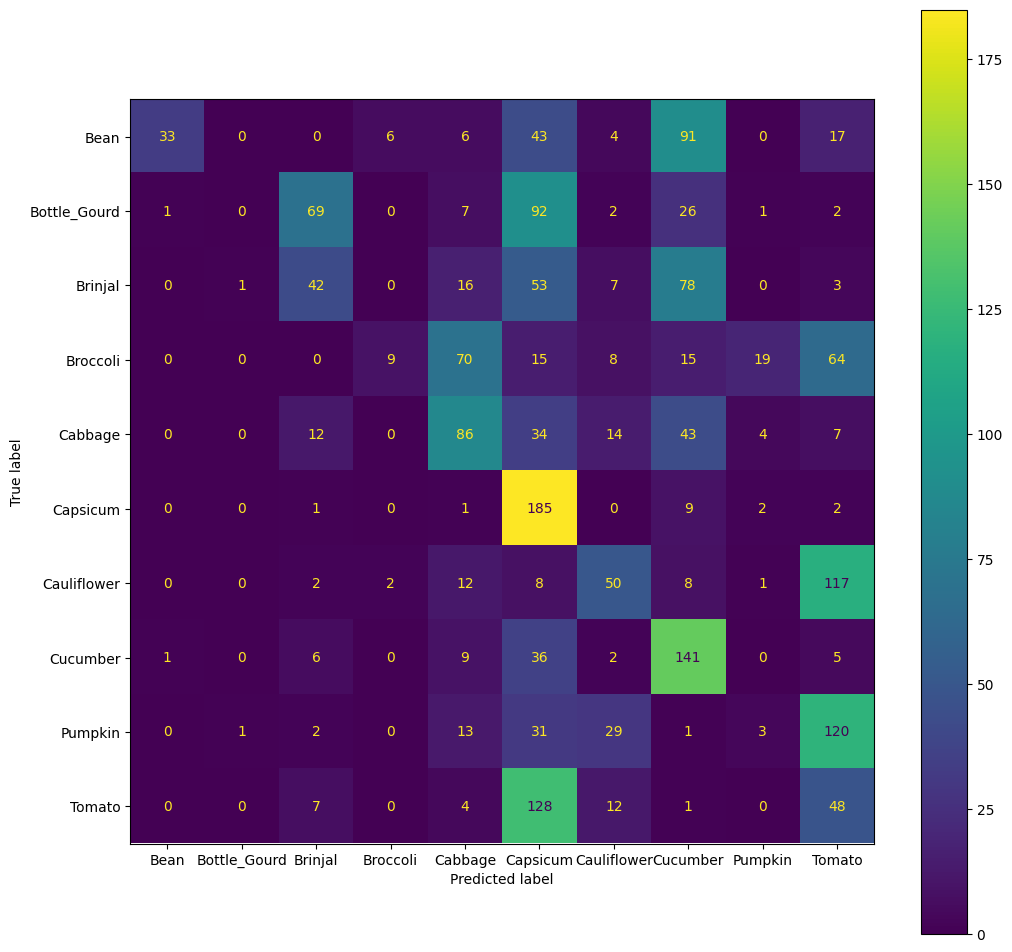

In [224]:
# Load the validation dataset from the directory `val_dir`.
validation_ds_raw = image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=batch_size  
)

#get classnames
class_names = validation_ds_raw.class_names

#prefetch
validation_ds = validation_ds_raw.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

#evaluates the trained model's performance on the validation dataset
test_loss, test_acc = model.evaluate(validation_ds)

#extract the true class labels from the validation dataset, which uses one-hot encoded labels. 
#needed for the classification and confusion matrix.
y_true = []
for _, labels in validation_ds:
    y_true.extend(np.argmax(labels, axis=1))

#predict and get the results
y_pred_probs = model.predict(validation_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

#classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred))

#confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=class_names)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax)
plt.show()

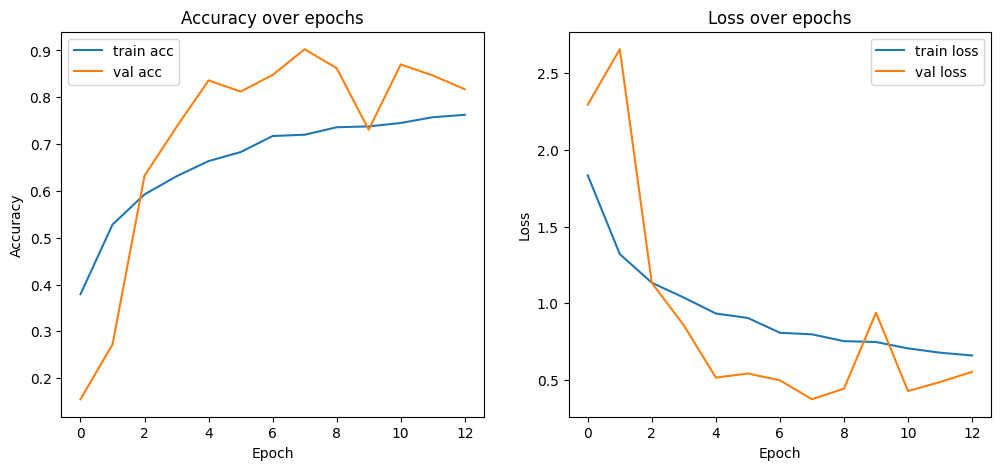

In [189]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# NOTE - HOLD ON FINAL SUBMISSION STUFF
## I NEED TO ENSURE THAT THERE'S NO CHANCE OF ANYONE EXCEEDING SIZE LIMITS OF MOODLE

### Compress and Save Model

For this you have a hard upper limit for model size of 400mb. Why? This is the largest that Moodle can accept, and I do not have any way to work around that. 

The model will probably need to be pruned to be smaller, then compressed as a zip. In testing this the size can very by a lot, pruning and compressing can get it down to less than 100mb. The size of yours does not matter, as long as it is small enough. 

In [190]:
# Compression Setup

model.save('vegetable_classifier.h5')
model.save('vegetable_classifier.keras')
#model = 


In [ ]:

import tensorflow_model_optimization as tfmot

end_step = np.ceil(1.0 * train_samples / batch_size).astype(np.int32) * epochs
print(end_step)

new_pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                   final_sparsity=0.90,
                                                   begin_step=0,
                                                   end_step=end_step,
                                                   frequency=100)
}

new_pruned_model = tfmot.sparsity.keras.prune_low_magnitude(model, **new_pruning_params)
new_pruned_model.summary()

new_pruned_model.compile(
    #loss=tf.keras.losses.categorical_crossentropy,
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [ ]:
logdir = "logs"
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir, profile_batch=0)
]

new_pruned_model.fit(train_ds,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=callbacks,
          validation_data=val_ds)

In [ ]:
final_model = tfmot.sparsity.keras.strip_pruning(new_pruned_model)
final_model.save("final.h5")
final_model.summary()

# Discussion

This deep learning project involves building and evaluating a convolutional neural network (CNN) to classify images of vegetables using TensorFlow and Keras. Initially, the dataset is explored by counting the number of images per class and visualizing samples from each category. The model architecture consists of several convolutional blocks with batch normalization and LeakyReLU activation, followed by max-pooling layers to reduce spatial dimensions. A final dense layer with softmax activation outputs the class probabilities for 10 vegetable categories. To improve generalization and reduce overfitting, data augmentation techniques such as rotation, zoom, and brightness variation are applied to the training data using the ImageDataGenerator. The model is trained with early stopping and learning rate reduction strategies to ensure efficient convergence. After training, the model’s performance is evaluated on a validation set through accuracy metrics, confusion matrix, and a detailed classification report. Predictions are logged to a text file along with the predicted and true labels for transparency and manual review. The pipeline demonstrates good practices in model training, evaluation, and deployment, ending with saving the model in both HDF5 (.h5) and native Keras format (.keras) for future reuse.

The training of the vegetable classification model was conducted over multiple epochs, which represent full iterations over the entire training dataset. Each epoch allowed the model to learn and adjust its weights in response to the training data, progressively improving its ability to generalize. To enhance training efficiency and prevent overfitting, an EarlyStopping callback was employed. This function monitored the validation accuracy and automatically halted the training process if there was no improvement over 5 consecutive epochs. By restoring the model weights from the epoch with the best validation performance, EarlyStopping ensured that the final model maintained optimal generalization performance without excessive training that could lead to overfitting. Additionally, a ReduceLROnPlateau callback was used to dynamically lower the learning rate when the validation loss stopped improving, allowing the model to fine-tune more carefully as it approached a performance plateau. These mechanisms collectively contributed to a more stable and efficient training process, yielding a model that performed well on unseen data.

Indications of failure were manually examined and it was determined that the accuracy of the model was not in the detection of the plant but rather the environemnt that the plant had been located on. Most failures were because the plant was being in a human hand. When cross examining the train data images and the validation images, it was noticed that these hand-held vegetables were not in the training directory. Because of the limitation in the training, the model failed to predict the correct vegetable. Therefore, the model composition was correct but the training conducted was imperfect. The argmax function is used in classification tasks where models output probability scores for each class. It returns the class label with the highest predicted probability. In this case, since most failures had low prediction values, it can be inferred — although beyond the scope of this lab—that the model may have assigned similarly low probabilities to all classes. As a result, argmax likely selected the highest among these nearly equal low values, which may not reflect strong model confidence in its training material.

## Convolutional Neural Network (CNN): 
The speciality of the CNN model in this vegetable classification project lies in its carefully tailored architecture, training strategy, and adaptability to complex image data. Beyond the basic construction, compilation, and training of the CNN, several advanced functions and testing mechanisms were integrated into the vegetable classifier project to enhance model performance, robustness, and evaluation:
- Multiple convolutional layers, Conv2D that progressively extract low- to high-level features  like edges, textures, shapes.
- ReLU activations after each convolution to introduce non-linearity and help the model learn complex patterns.
- MaxPooling2D layers to reduce spatial dimensions, control overfitting, and improve computational efficiency.
- A Flatten layer followed by Dense layers, enabling the model to interpret extracted features and perform classification.
- The model integrates Dropout layers in the fully connected section, which randomly disables a fraction of neurons during training to prevent the network from becoming too reliant on any single path of information, thus enhancing its ability to generalize.
- data augmentation using ImageDataGenerator: Instead of manually preprocessing the data, the model leverages on-the-fly data augmentation using ImageDataGenerator.
- EarlyStopping ensured the model stops training when it ceases to improve, preventing waste of resources and avoiding overfitting. 
- ReduceLROnPlateau fine-tunes the learning rate mid-training when the model gets stuck, ensuring smoother convergence and better performance.

## Data Augmentation (ImageDataGenerator):
To improve generalization and reduce overfitting, the training images were dynamically augmented using the ImageDataGenerator. This function applied random transformations such as rotation, shifting, zooming, brightness adjustment, shearing, and horizontal flipping. These augmentations allowed the model to train on a more diverse dataset without the need for additional real images.

## Custom Visualization (plot_images):
A plot_images() function was defined to visualize sample images from each vegetable class. This helped ensure that the data was loaded correctly and gave insight into the visual complexity of each class, aiding in model interpretability.

## Callbacks – EarlyStopping and ReduceLROnPlateau:
The EarlyStopping callback monitored the val_accuracy during training and stopped the process once performance stopped improving for 5 epochs. Meanwhile, ReduceLROnPlateau dynamically adjusted the learning rate by reducing it by a factor of 0.5 if the validation loss plateaued, allowing the optimizer to make finer updates in later epochs.

## Directory Checks and Class Balancing:
Custom scripts ensured that the test directory existed and automatically created it if missing. The number of training images per class was also computed and displayed using class_counts, helping check for class imbalance early in the pipeline.

## Custom Testing Loop with Confidence Logging:
A manually coded testing loop evaluated model performance by predicting on every image in the validation directory. It logged each prediction with its confidence score and whether it was correct, writing results into a log file. This provided transparency into prediction quality and allowed for individual error inspection.
Detailed Evaluation Strategy: The model’s specialty isn't just in training but in how it is tested and validated. Custom code was written to go beyond basic metrics, offering deep insight into where and why the model performs well or poorly.
- Predict on each image and log its prediction confidence.
- Save correct vs. incorrect predictions to a file.
- Generate a full classification report (precision, recall, F1).
- Create a confusion matrix heatmap for visual error analysis.

## Performance Metrics: Classification Report & Confusion Matrix:
Beyond accuracy, the model’s performance was evaluated using a classification report that included precision, recall, and F1 scores for each class. A confusion matrix was also plotted to show the distribution of true vs. predicted labels, identifying misclassifications across categories.

## Training History Visualization:
Loss and accuracy trends for both training and validation sets were plotted over all epochs. These visualizations helped detect overfitting or underfitting, and evaluate the impact of learning rate changes.

## Model Saving:
The final trained model was saved in both HDF5 (.h5) and Keras (.keras) formats for future use or evaluation for this assignment, ensuring the trained weights and architecture could be easily reused or deployed without retraining.


